## pba-modul2-en-text-classification

Inisialisasi

In [65]:
from contraction import CONTRACTION_MAP
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import Word2Vec
from gensim import models

Text Normalization

In [66]:
stopword_list=nltk.corpus.stopwords.words('english')
wnl=WordNetLemmatizer()

In [67]:
#Membuat Fungsi Tokenisasi Kata
def tokenize_text(text):
    tokens=nltk.word_tokenize(text)
    tokens=[token.strip() for token in tokens]
    return tokens

In [68]:
# Membuat Fungsi Memperpanjang Singkatan menggunakan pattern
def expand_contractions(text, contraction_mapping):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                            if contraction_mapping.get(match)\
                            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [69]:
#Import library
#from pattern.en import tag
from nltk.corpus import wordnet as wn

In [70]:
def pos_tag_text(text):
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    tagged_text = nltk.pos_tag(nltk.word_tokenize(text))
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                            for word, pos_tag in
                            tagged_text]
    return tagged_lower_text

In [71]:
#Membuat Fungsi Lemmatize teks berdasarkan POS tags
def lemmatize_text(text):
    pos_tagged_text=pos_tag_text(text)
    lemmatized_tokens=[wnl.lemmatize(word, pos_tag) if pos_tag
                        else word for word,
                        pos_tag in pos_tagged_text]
    lemmatize_text=' '.join(lemmatized_tokens)
    return lemmatize_text

In [72]:
#Membuat Fungsi Untuk Menghilangkan Karakter Spesial
def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [73]:
#Membuat Fungsi Untuk Menghilangkan Kata-kata yang tak penting (Stopwords
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [74]:
#Membuat Fungsi Normalisasi Baccan/Corpus dengan menggunakan Fungsi-fungsi
#yang telah di buat sebelumnya
def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
        text = lemmatize_text(text)
        text = remove_stopwords(text)
        normalized_corpus.append(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
    return normalized_corpus

Langkah 3: Feature Extraction

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [76]:
CORPUS = [
'the sky is blue',
'sky is blue and sky is beautiful',
'the beautiful sky is so blue',
'i love blue cheese'
]

In [77]:
import pandas as pd
def display_features(features, feature_names):
    df = pd.DataFrame(data=features,columns=feature_names)
    print (df)

In [78]:
# MEMBUAT FUNGSI DENGAN MENGGUNAKAN LIBRARY BAG OF WORDS MODEL
def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

Bag of Words Model (BOW)

In [79]:
# Bag of Words Model
#Corpus BOW
bow_vectorizer, bow_features = bow_extractor(CORPUS)
features = bow_features.todense()
print (features)

[[0 0 1 0 1 0 1 0 1]
 [1 1 1 0 2 0 2 0 0]
 [0 1 1 0 1 0 1 1 1]
 [0 0 1 1 0 1 0 0 0]]


In [80]:
feature_names = bow_vectorizer.get_feature_names_out()

print (feature_names)

['and' 'beautiful' 'blue' 'cheese' 'is' 'love' 'sky' 'so' 'the']


In [81]:
display_features(features, feature_names)

   and  beautiful  blue  cheese  is  love  sky  so  the
0    0          0     1       0   1     0    1   0    1
1    1          1     1       0   2     0    2   0    0
2    0          1     1       0   1     0    1   1    1
3    0          0     1       1   0     1    0   0    0


TF-IDF


In [82]:
# MEMBUAT FUNGSI DENGAN MENGGUNAKAN LIBRARY TFIDF TRANSFORMER SETELAH CORPUS
# DIUBAH MENJADI MATRIX/ VEKTORISASI OLEH BOW EXTRACTOR
def tfidf_transformer(bow_matrix):
    transformer = TfidfTransformer(norm='l2',
                                    smooth_idf=True,
                                    use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix

In [83]:
def tfidf_extractor(corpus, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(min_df=1,
                                    norm='l2',
                                    smooth_idf=True,
                                    use_idf=True,
                                    ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [84]:
import numpy as np
feature_names = bow_vectorizer.get_feature_names_out()

In [85]:
tfidf_trans, tdidf_features = tfidf_transformer(bow_features)
features = np.round(tdidf_features.todense(), 2)
display_features(features, feature_names)

    and  beautiful  blue  cheese    is  love   sky    so   the
0  0.00       0.00  0.40    0.00  0.49  0.00  0.49  0.00  0.60
1  0.44       0.35  0.23    0.00  0.56  0.00  0.56  0.00  0.00
2  0.00       0.43  0.29    0.00  0.35  0.00  0.35  0.55  0.43
3  0.00       0.00  0.35    0.66  0.00  0.66  0.00  0.00  0.00


Advanced Word Vectorization Model

In [86]:
# MODEL VEKTORISASI KATA YANG LEBIH MAJU
#MEMBUAT FUNGSI VEKTORISASI DENGAN MENGGUNAKAN LIBRARY NUMPy
# def average_word_vectors(words, model, vocabulary, num_features):
#     feature_vector = np.zeros((num_features,),dtype="float64")
#     nwords = 0.
#     for word in words:
#         if word in vocabulary:
#             nwords = nwords + 1.
#             feature_vector = np.add(feature_vector, model[word])
#     if nwords:
#         feature_vector = np.divide(feature_vector, nwords)
#     return feature_vector

In [87]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model.wv[word])  # Use model.wv[word] to access word vectors

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector


In [88]:
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)


In [89]:
# def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model,num_features):
#     word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)]
#                     if tfidf_vocabulary.get(word)
#                     else 0 for word in words]
#     word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words,word_tfidfs)}
#     feature_vector = np.zeros((num_features,),dtype="float64")
#     vocabulary = set(model.wv.index_to_key)
#     wts = 0.
#     for word in words:
#         if word in vocabulary:
#             word_vector = model[word]
#             weighted_word_vector = word_tfidf_map[word] * word_vector
#             wts = wts + word_tfidf_map[word]
#             feature_vector = np.add(feature_vector, weighted_word_vector)
#     if wts:
#         feature_vector = np.divide(feature_vector, wts)
#     return feature_vector

In [90]:
def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)]
                    if tfidf_vocabulary.get(word)
                    else 0 for word in words]
    word_tfidf_map = {word: tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    feature_vector = np.zeros((num_features,), dtype="float64")
    vocabulary = set(model.wv.index_to_key)
    wts = 0.
    for word in words:
        if word in vocabulary:
            word_vector = model.wv[word]  # Use model.wv to access word vectors
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
    return feature_vector


In [91]:
def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors,tfidf_vocabulary, model, num_features):
    docs_tfidfs = [(doc, doc_tfidf)
                    for doc, doc_tfidf
                    in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf,tfidf_vocabulary,model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features)

In [92]:
# Advanced Words Vectorization
import nltk

In [93]:
TOKENIZED_CORPUS = [nltk.word_tokenize(sentence)
for sentence in CORPUS]

In [94]:
model = Word2Vec(TOKENIZED_CORPUS,
                vector_size=10,  # Use vector_size instead of size
                window=10,
                min_count=2,
                sample=1e-3)

In [95]:
tfidf_vectorizer, tdidf_features = tfidf_extractor(CORPUS)
display_features(np.round(tdidf_features.todense(), 2), feature_names)

    and  beautiful  blue  cheese    is  love   sky    so   the
0  0.00       0.00  0.40    0.00  0.49  0.00  0.49  0.00  0.60
1  0.44       0.35  0.23    0.00  0.56  0.00  0.56  0.00  0.00
2  0.00       0.43  0.29    0.00  0.35  0.00  0.35  0.55  0.43
3  0.00       0.00  0.35    0.66  0.00  0.66  0.00  0.00  0.00


In [96]:
avg_word_vec_features = averaged_word_vectorizer(corpus=TOKENIZED_CORPUS,
model=model,
num_features=10)
print (np.round(avg_word_vec_features, 3))

[[ 0.011  0.022 -0.004  0.03  -0.02  -0.032  0.002  0.063 -0.04  -0.02 ]
 [ 0.036  0.011  0.032  0.027 -0.014 -0.032  0.031  0.028 -0.061 -0.059]
 [-0.006  0.016  0.016  0.009 -0.02  -0.029  0.018  0.039 -0.032 -0.025]
 [-0.005  0.002  0.051  0.09  -0.093 -0.071  0.065  0.09  -0.05  -0.038]]


In [97]:
corpus_tfidf = tdidf_features
vocab = tfidf_vectorizer.vocabulary_
wt_tfidf_word_vec_features = tfidf_weighted_averaged_word_vectorizer(corpus=TOKENIZED_CORPUS,
                                                                     tfidf_vectors=corpus_tfidf,
                                                                     tfidf_vocabulary=vocab,
                                                                     model=model,num_features=10)
print (np.round(wt_tfidf_word_vec_features, 3))

[[ 0.006  0.024 -0.011  0.023 -0.015 -0.028 -0.006  0.064 -0.034 -0.012]
 [ 0.049  0.013  0.025  0.027 -0.005 -0.029  0.023  0.027 -0.067 -0.062]
 [-0.013  0.017  0.014  0.    -0.017 -0.026  0.015  0.035 -0.026 -0.021]
 [-0.005  0.002  0.051  0.09  -0.093 -0.071  0.065  0.09  -0.05  -0.038]]


Langkah 4: Model Training

In [98]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [99]:
def get_data():
    data = fetch_20newsgroups(subset='all',
                                shuffle=True,
                                remove=('headers', 'footers', 'quotes'))
    return data


In [100]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=0.33,
                                                        random_state=42)
    return train_X, test_X, train_Y, test_Y

In [101]:
def remove_empty_docs(corpus, labels):
    filtered_corpus = []
    filtered_labels = []
    for doc, label in zip(corpus, labels):
        if doc.strip():
            filtered_corpus.append(doc)
            filtered_labels.append(label)
    return filtered_corpus, filtered_labels

In [102]:
dataset = get_data()

Inget run ulang di sini

In [103]:
print (dataset.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [104]:
corpus, labels = dataset.data, dataset.target
corpus, labels = remove_empty_docs(corpus, labels)

In [105]:
print ('Sample document:', corpus[10])
print ('Class label:',labels[10])
print ('Actual class label:', dataset.target_names[labels[10]])

Sample document: the blood of the lamb.

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
Class label: 19
Actual class label: talk.religion.misc


In [106]:
train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(corpus,
labels,test_data_proportion=0.3)


disini juga mulai traning

In [107]:
norm_train_corpus = normalize_corpus(train_corpus)

test tranning

In [108]:
norm_test_corpus = normalize_corpus(test_corpus)

Feature Extraction Setelah proses normalisasi selesai maka membuat model dengan meng-
gunakan 3 algoritma ekstrasi fitur yaitu: BOW, TF-ID, dan Advanced Words Vectorization
(Word2Vec)

In [109]:
import nltk
import gensim

In [110]:
# bag of words features
bow_vectorizer, bow_train_features = bow_extractor(norm_train_corpus)
bow_test_features = bow_vectorizer.transform(norm_test_corpus)

In [112]:
# tfidf features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)

In [113]:
# tokenize documents
tokenized_train = [nltk.word_tokenize(text)
        for text in norm_train_corpus]
tokenized_test = [nltk.word_tokenize(text)
        for text in norm_test_corpus]

In [118]:
model = gensim.models.Word2Vec(tokenized_train,
                               vector_size=500,  # Use 'vector_size' instead of 'size'
                               window=100,
                               min_count=30,
                               sample=1e-3)


In [119]:
# averaged word vector features
avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,
                                                    model=model,
                                                    num_features=500)
avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,
                                                    model=model,
                                                    num_features=500)

In [122]:
# tfidf weighted averaged word vector features
vocab = tfidf_vectorizer.vocabulary_
tfidf_wv_train_features =tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train,
                                                                 tfidf_vectors=tfidf_train_features,
                                                                 tfidf_vocabulary=vocab,
                                                                 model=model,
                                                                 num_features=500)
tfidf_wv_test_features =tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test,
                                                                tfidf_vectors=tfidf_test_features,
                                                                tfidf_vocabulary=vocab,
                                                                model=model,
                                                                num_features=500)

Model Training and Evaluation

In [123]:
from sklearn import metrics
import numpy as np

In [124]:
def get_metrics(true_labels, predicted_labels):
    print ('Accuracy:', np.round(
                                    metrics.accuracy_score(true_labels,
                                    predicted_labels),
                                    2))
    print ('Precision:', np.round(
                                    metrics.precision_score(true_labels,
                                    predicted_labels,
                                    average='weighted'),
                                    2))
    print ('Recall:', np.round(
                                metrics.recall_score(true_labels,
                                predicted_labels,
                                average='weighted'),
                                2))
    print ('F1 Score:', np.round(
                                metrics.f1_score(true_labels,
                                predicted_labels,
                                average='weighted'),
                                2))

In [125]:
def train_predict_evaluate_model(classifier,train_features, train_labels,test_features, test_labels):
    # build model
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features)
    # evaluate model prediction performance
    get_metrics(true_labels=test_labels,
                predicted_labels=predictions)
    return predictions
    

Setelah membuat fungsi, kita dapat melakukan proses klasifikasi dengan menggunakan algoritma
naive bayes dan SVM dengan mencoba ke 3 model dari ekstrasi fitur yang telah dilakukan.

In [126]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [127]:
mnb = MultinomialNB()
svm = SGDClassifier(loss='hinge', max_iter=100)

In [129]:
# Multinomial Naive Bayes with bag of words features
print("MultinomialNB with Bags of Words")
mnb_bow_predictions = train_predict_evaluate_model(classifier=mnb,
                                                    train_features=bow_train_features,
                                                    train_labels=train_labels,
                                                    test_features=bow_test_features,
                                                    test_labels=test_labels)

MultinomialNB with Bags of Words
Accuracy: 0.68
Precision: 0.72
Recall: 0.68
F1 Score: 0.66


In [131]:
# Support Vector Machine with bag of words features
print("SVM with Bags of Words")
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                                    train_features=bow_train_features,
                                                    train_labels=train_labels,
                                                    test_features=bow_test_features,
                                                    test_labels=test_labels)

SVM with Bags of Words
Accuracy: 0.65
Precision: 0.69
Recall: 0.65
F1 Score: 0.66


In [132]:
# Support Vector Machine with bag of words features
print("SVM with Bags of Words")
svm_bow_predictions = train_predict_evaluate_model(classifier=svm,
                                                    train_features=bow_train_features,
                                                    train_labels=train_labels,
                                                    test_features=bow_test_features,
                                                    test_labels=test_labels)

SVM with Bags of Words
Accuracy: 0.65
Precision: 0.7
Recall: 0.65
F1 Score: 0.66


In [133]:
# Multinomial Naive Bayes with tfidf features
print("MultinomialNB with TFIDF")
mnb_tfidf_predictions = train_predict_evaluate_model(classifier=mnb,
                                                    train_features=tfidf_train_features,
                                                    train_labels=train_labels,
                                                    test_features=tfidf_test_features,
                                                    test_labels=test_labels)

MultinomialNB with TFIDF
Accuracy: 0.72
Precision: 0.78
Recall: 0.72
F1 Score: 0.71


In [134]:
# Support Vector Machine with tfidf features
print("SVM with TFIDF")
svm_tfidf_predictions = train_predict_evaluate_model(classifier=svm,
                                                    train_features=tfidf_train_features,
                                                    train_labels=train_labels,
                                                    test_features=tfidf_test_features,
                                                    test_labels=test_labels)

SVM with TFIDF
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.77


In [135]:
# Support Vector Machine with averaged word vector features
print("SVM with Averaged Word Vector")
svm_avgwv_predictions = train_predict_evaluate_model(classifier=svm,
                                                    train_features=avg_wv_train_features,
                                                    train_labels=train_labels,
                                                    test_features=avg_wv_test_features,
                                                    test_labels=test_labels)

SVM with Averaged Word Vector
Accuracy: 0.52
Precision: 0.54
Recall: 0.52
F1 Score: 0.51


In [136]:
# Support Vector Machine with tfidf weighted averaged word vector features
print("SVM with TFIDF Weighted Averaged Word Vector")
svm_tfidfwv_predictions = train_predict_evaluate_model(classifier=svm,
                                                       train_features=tfidf_wv_train_features,
                                                       train_labels=train_labels,
                                                        test_features=tfidf_wv_test_features,
                                                        test_labels=test_labels)

SVM with TFIDF Weighted Averaged Word Vector
Accuracy: 0.52
Precision: 0.54
Recall: 0.52
F1 Score: 0.5


In [137]:
import pandas as pd
cm = metrics.confusion_matrix(test_labels, svm_tfidf_predictions)
pd.DataFrame(cm, index=range(0,20), columns=range(0,20))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,154,0,0,0,1,0,2,3,4,0,5,5,4,7,6,31,5,6,9,21
1,1,228,9,7,4,17,5,2,0,2,1,3,3,4,6,2,2,0,1,0
2,1,19,228,13,9,17,6,0,0,1,0,3,8,2,5,1,0,0,1,0
3,1,8,24,221,14,4,7,4,1,2,1,3,6,2,1,0,1,0,0,0
4,0,5,6,16,226,4,3,3,2,1,1,2,11,4,6,0,1,0,1,0
5,0,18,23,1,1,273,1,0,1,0,0,0,4,2,1,0,0,0,0,0
6,0,1,4,15,11,2,273,8,4,2,0,1,9,2,3,0,2,1,1,0
7,1,4,2,0,1,1,5,249,22,1,1,1,9,4,3,3,2,2,4,1
8,3,0,0,3,1,1,3,30,255,4,2,3,1,3,2,3,2,1,5,0
9,1,2,1,0,2,1,3,3,6,279,13,1,2,3,2,1,3,0,1,1


In [139]:
class_names = dataset.target_names
print (class_names[0], '->', class_names[15])
print (class_names[18], '->', class_names[16])
print (class_names[19], '->', class_names[15])
print('---------------------------------------------------')

alt.atheism -> soc.religion.christian
talk.politics.misc -> talk.politics.guns
talk.religion.misc -> soc.religion.christian
---------------------------------------------------


In [140]:
import re
num = 0
for document, label, predicted_label in zip(test_corpus, test_labels,svm_tfidf_predictions):
    if label == 0 and predicted_label == 15:
        print ('Actual Label:', class_names[label])
        print ('Predicted Label:', class_names[predicted_label])
        print ('Document:-')
        print (re.sub('\n', ' ', document))
        print
        num += 1
        if num == 4:
            break
print('--------------------------------------------------')


Actual Label: alt.atheism
Predicted Label: soc.religion.christian
Document:-
I would like a list of Bible contadictions from those of you who dispite being free from Christianity are well versed in the Bible. 
Actual Label: alt.atheism
Predicted Label: soc.religion.christian
Document:-
  They spent quite a bit of time on the wording of the Constitution.  They picked words whose meanings implied the intent.  We have already looked in the dictionary to define the word.  Isn't this sufficient?   But we were discussing it in relation to the death penalty.  And, the Constitution need not define each of the words within.  Anyone who doesn't know what cruel is can look in the dictionary (and we did).
Actual Label: alt.atheism
Predicted Label: soc.religion.christian
Document:-
Our Lord and Savior David Keresh has risen!   	He has been seen alive!   	Spread the word!     --------------------------------------------------------------------------------
Actual Label: alt.atheism
Predicted Label: s

In [142]:
num = 0
for document, label, predicted_label in zip(test_corpus, test_labels,svm_tfidf_predictions):
    if label == 18 and predicted_label == 16:
        print ('Actual Label:', class_names[label])
        print ('Predicted Label:', class_names[predicted_label])
        print ('Document:-')
        print (re.sub('\n', ' ', document))
        print
        num += 1
        if num == 4:
            break

Actual Label: talk.politics.misc
Predicted Label: talk.politics.guns
Document:-
After the initial gun battle was over, they had 50 days to come out peacefully. They had their high priced lawyer, and judging by the posts here they had some public support. Can anyone come up with a rational explanation why the didn't come out (even after they negotiated coming out after the radio sermon) that doesn't include the Davidians wanting to commit suicide/murder/general mayhem?
Actual Label: talk.politics.misc
Predicted Label: talk.politics.guns
Document:-
Yesterday, the FBI was saying that at least three of the bodies had gunshot wounds, indicating that they were shot trying to escape the fire.  Today's paper quotes the medical examiner as saying that there is no evidence of gunshot wounds in any of the recovered bodies.  At the beginning of this siege, it was reported that while Koresh had a class III (machine gun) license, today's paper quotes the government as saying, no, they didn't have a 

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

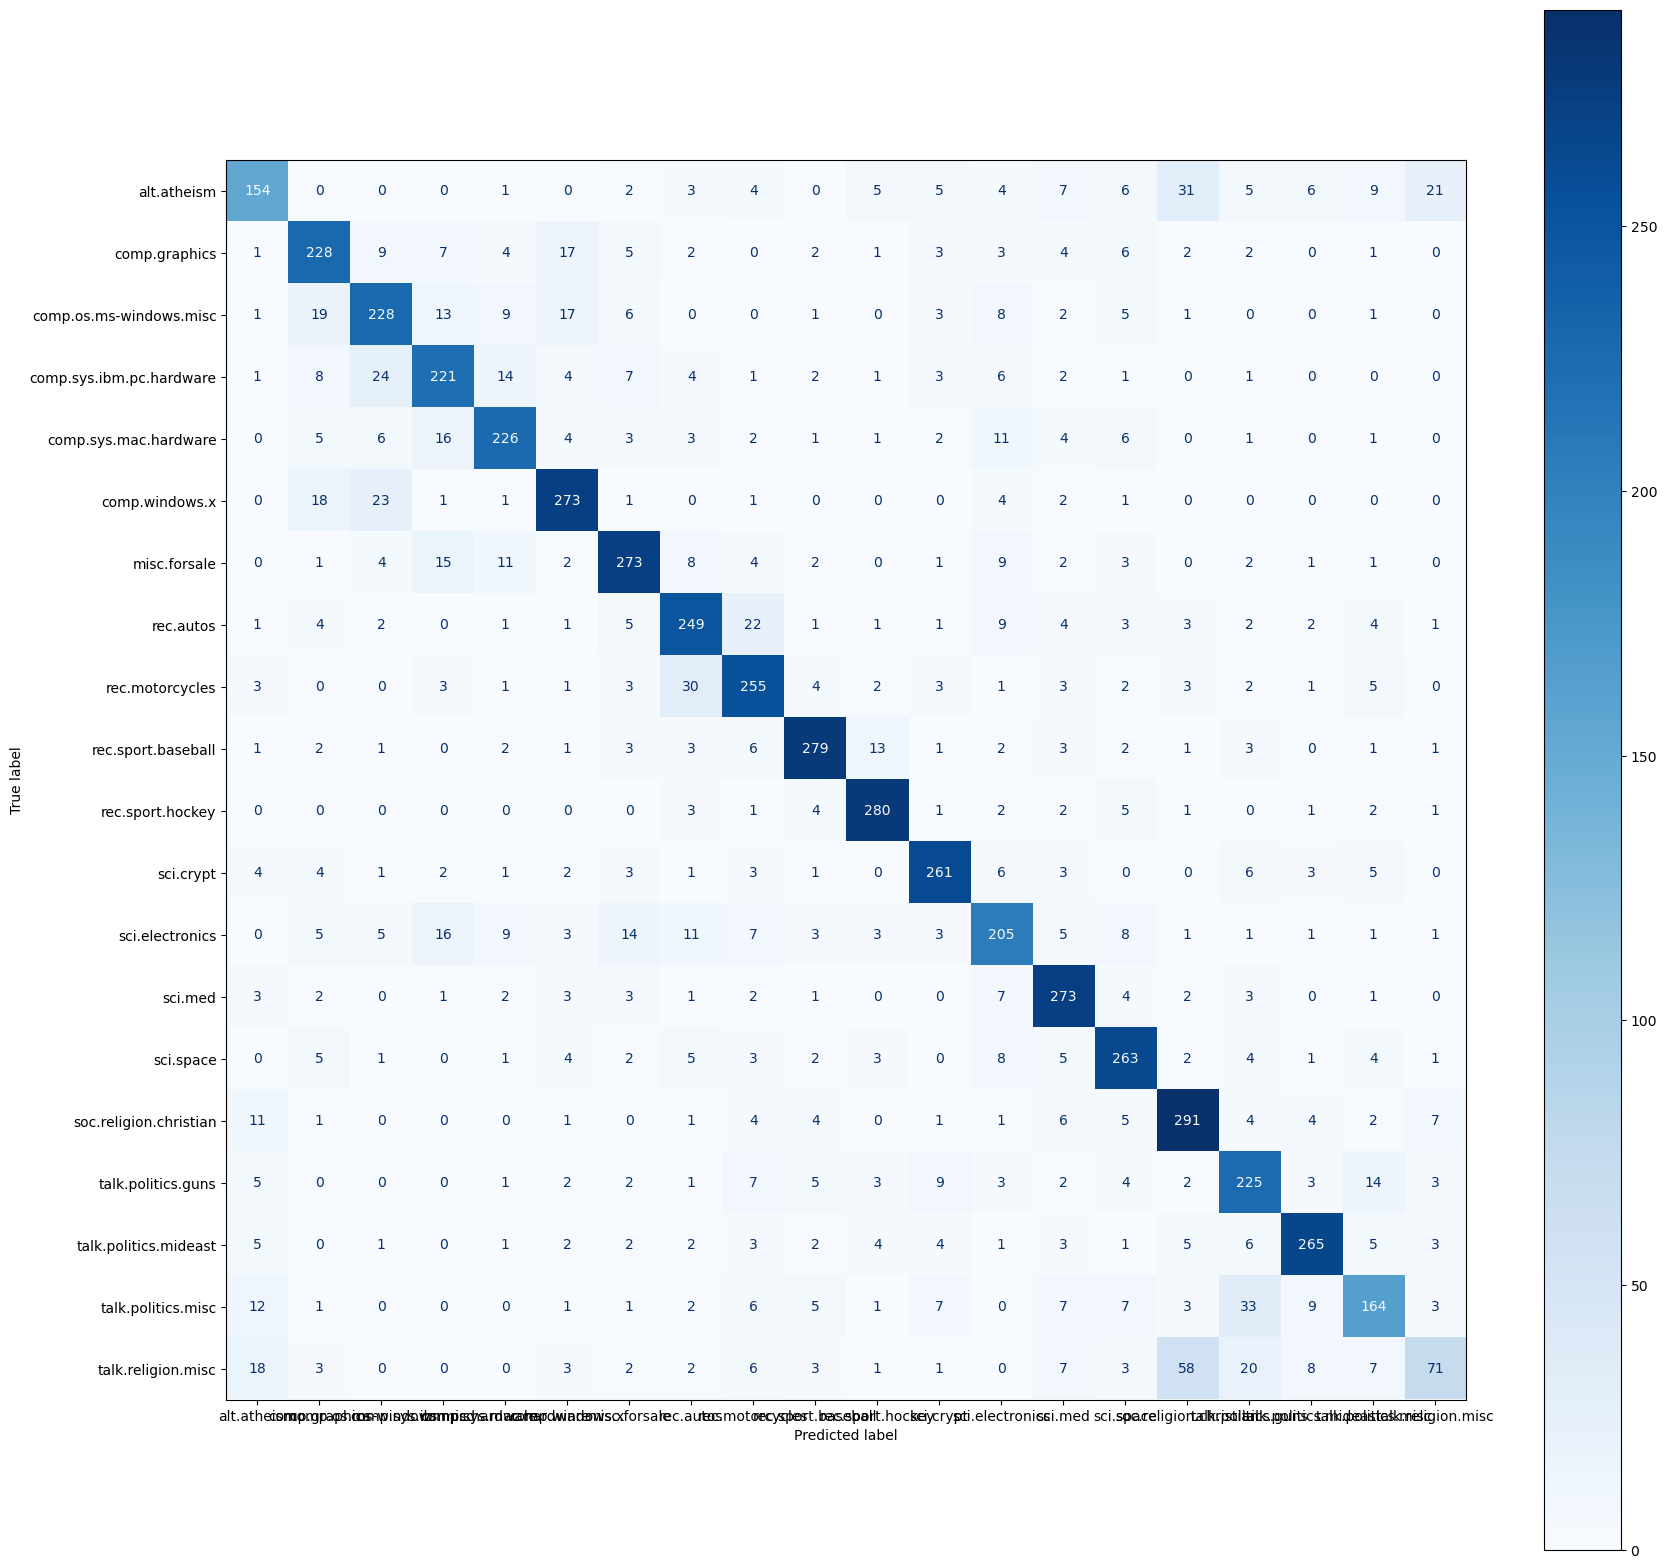

In [144]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=dataset.target_names)
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(ax=ax,cmap=plt.cm.Blues)